# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [25]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as prep
import threading as thrd
import time

import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
#matplot inline


# np.set_printoptions(precision=8)

Define functions and class

In [2]:
class MethodException(Exception):
    def __init__(self, msg, value):
        self.msg=msg
        self.value=value
        
# def PolynomialFeature
def polyFeature(X, degree=2):
    poly = prep.PolynomialFeatures(degree,include_bias = False)
    polyArray = poly.fit_transform(X)
    return polyArray

def normalizeFeature(X, method):
    try:
        if X.ndim == 1:  # Reshape the 1d array
            X=np.reshape(X,(-1,1))
        X_norm=np.ones((X.shape[0],X.shape[1]+1), dtype=np.float64)
        if method == 'std':
            X_norm[:,1:]=(X-X.mean(0))/X.std(0)     
        elif method == 'range':
            X_norm[:,1:]=(X-X.min(0))/(X.max(0)-X.min(0))
        else:
            raise MethodException('method should be either \'std\' or \'range\'(case sensitive)', method)
    except MethodException as ex:
        print(f'The error is: {ex.msg}, here the input method is \'{ex.value}\'')
    else:
        return X_norm

# cost (error) function
def computeCost(X, y, theta):
    inner = np.power(((X @ theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

# normal equation
def normalEq(X,y):
    theta=np.linalg.pinv(X.T@X)@X.T@y
    return theta

# normal equation with regulization
def normalRegEq(X,y,beta):
    L=np.eye(X.shape[1])
    L[0,0]=0
    theta=np.linalg.inv(X.T@X+beta*L)@X.T@y
    return theta
    
# def linearRegCostFunction(X, y, theta, reg):


# Data Import and Initialization

In [3]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [4]:
tcv=df.sample(frac=0.8) # random_state=200
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


### Random Method 2: random array

In [ ]:
# idx=np.arange(0,len(df))
# np.random.shuffle(idx)
# temp_split=math.floor(0.8*len(df))
# #idx[0:20]
# train=df.iloc[idx[0:temp_split],:]
# test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
# print(train.shape)
# print(test.shape)

## Split the data into data and results

In [5]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

# print(test_data)
# J=J.tolist()

## Add the polynominal features

In [6]:
degree = 2
print(f'The polynominal degree is {degree}.\n')


# test data
test_data_poly = polyFeature(test_data, degree)
print('test data = \n', test_data_poly, '\n')


The polynominal degree is 2.

test data = 
 [[3.2000e+00 1.4800e+02 1.0240e+01 4.7360e+02 2.1904e+04]
 [3.2000e+00 1.9300e+02 1.0240e+01 6.1760e+02 3.7249e+04]
 [2.6000e+00 1.5700e+02 6.7600e+00 4.0820e+02 2.4649e+04]
 ...
 [1.0500e+00 6.1000e+02 1.1025e+00 6.4050e+02 3.7210e+05]
 [2.0000e-01 1.0900e+02 4.0000e-02 2.1800e+01 1.1881e+04]
 [3.0000e+00 1.4900e+02 9.0000e+00 4.4700e+02 2.2201e+04]] 



## Data Normalization (Two methods, range or stand deviation)  

(__We should try both__)

In [7]:
# Normalization method
method='std'

# test data
test_data_norm=normalizeFeature(test_data_poly, method)
print('normalized test_data = \n', test_data_norm, '\n')

# test the normalize method is right
# t=test_data_poly[:,1]
# print(t.ndim)
# t_norm=normalizeFeature(t,'std')
# print(t_norm)

normalized test_data = 
 [[ 1.          1.4546216  -0.29033091  1.64521088  1.03973227 -0.30329979]
 [ 1.          1.4546216   0.07198359  1.64521088  1.80539352 -0.13344035]
 [ 1.          0.87919894 -0.21786801  0.73922123  0.69199444 -0.27291438]
 ...
 [ 1.         -0.6073096   3.4294312  -0.73366279  1.92715493  3.57314835]
 [ 1.         -1.42249171 -0.6043368  -1.01027601 -1.36252993 -0.41424806]
 [ 1.          1.26281405 -0.28227947  1.32238698  0.89829762 -0.30001219]] 



# Model Training

## Method 1: Normal Equation

### Training without regulation

In [ ]:
theta=normalEq(train_data_norm, train_J) 
print(f'theta = {theta}')
error_train=computeCost(train_data_norm, train_J, theta)
error_test=computeCost(test_data_norm, test_J, theta)

print('The training error is ', error_train)
print('The test error is ', error_test)

# OTHER PRINT EXPRESSION WITH FORMAT
# print('The training error is %.10f'%error)
# print('error = {:.10f}'.format(error))
# print(f'error = {error}')
# print('error= ', error)

### Training with regulation

In [29]:
featureSize=test_data_norm.shape[1]
beta_range=np.geomspace(0.001,15, num = 100, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
theta_reg=np.zeros((beta_range.size, featureSize))
error_train_reg=np.zeros(beta_range.size)
error_cv_reg=np.zeros(beta_range.size)

def train_model_single(i, j, beta, error_train_reg_multismpl, error_cv_reg_multismpl):
    print(f'{thrd.current_thread().name} is running...\n')
    # Split into train set and cv set
    train=tcv.sample(frac=0.75, random_state = int((157*j+71*i)/3))
    cv=tcv.drop(train.index)

    train_data=train.loc[:,['V','T']]
    train_unc=train.uncertainty.values
    train_J=train.J.values

    cv_data=cv.loc[:,['V','T']]
    cv_unc=cv.uncertainty.values
    cv_J=cv.J.values

    # add polynominal features
    train_data_poly = polyFeature(train_data, degree)
    cv_data_poly = polyFeature(cv_data, degree)

    # train data normalization
    train_data_norm=normalizeFeature(train_data_poly, method)

    # cross valiation data normalization
    cv_data_norm=normalizeFeature(cv_data_poly, method)

    theta_reg_multismpl=normalRegEq(train_data_norm, train_J, beta)
    error_train_reg_multismpl[j]=computeCost(train_data_norm, train_J, theta_reg_multismpl)
    error_cv_reg_multismpl[j]=computeCost(cv_data_norm, cv_J, theta_reg_multismpl)
    
    print(f'thread {thrd.current_thread().name} ended. \n')


def train_model_loop(num, epoch):
    # theta_reg_multismpl=np.zeros((epoch, featureSize))
    error_train_reg_multismpl=np.zeros(epoch)
    error_cv_reg_multismpl=np.zeros(epoch)
    beta_array=np.zeros(num)

    for i in range(0,num):
        for index, beta in enumerate(beta_range):
            threads=[]
            for j in range(0,epoch,1):
                th = thrd.Thread(target=train_model_single, name=f'Threading {i}-{index}-{j}', args=(i,j,beta, 
                                 error_train_reg_multismpl, error_cv_reg_multismpl))
                threads.append(th)
            for th in threads:
                th.daemon=True
                th.start()
            for th in threads:
                th.join()
            error_train_reg[index] = error_train_reg_multismpl.sum(0)/epoch
            error_cv_reg[index] = error_cv_reg_multismpl.sum(0)/epoch
        idx=error_cv_reg.argmin()
        beta_array[i] = beta_range[idx]
    return beta_array

Threading 0-0-0 is running...
Threading 0-0-1 is running...


Threading 0-0-2 is running...

Threading 0-0-3 is running...

Threading 0-0-4 is running...

Threading 0-0-5 is running...

Threading 0-0-6 is running...

Threading 0-0-7 is running...

Threading 0-0-8 is running...

Threading 0-0-9 is running...

thread Threading 0-0-5 ended. 

thread Threading 0-0-2 ended. 

thread Threading 0-0-1 ended. 
thread Threading 0-0-0 ended. 


thread Threading 0-0-6 ended. 

thread Threading 0-0-7 ended. 
thread Threading 0-0-3 ended. 


thread Threading 0-0-4 ended. 

thread Threading 0-0-9 ended. 
thread Threading 0-0-8 ended. 


Threading 0-1-0 is running...

Threading 0-1-1 is running...

Threading 0-1-2 is running...

Threading 0-1-3 is running...

Threading 0-1-4 is running...

Threading 0-1-5 is running...

Threading 0-1-6 is running...

Threading 0-1-7 is running...

Threading 0-1-8 is running...

Threading 0-1-9 is running...

thread Threading 0-1-1 ended. 

thread Threading 0-1-9 ended

thread Threading 0-14-0 ended. 
thread Threading 0-14-1 ended. 
thread Threading 0-14-5 ended. 



thread Threading 0-14-2 ended. 

thread Threading 0-14-3 ended. 

thread Threading 0-14-9 ended. 

thread Threading 0-14-7 ended. 

thread Threading 0-14-8 ended. 

thread Threading 0-14-6 ended. 

thread Threading 0-14-4 ended. 

Threading 0-15-0 is running...

Threading 0-15-1 is running...

Threading 0-15-2 is running...

Threading 0-15-3 is running...

Threading 0-15-4 is running...

Threading 0-15-5 is running...

Threading 0-15-6 is running...

Threading 0-15-7 is running...

Threading 0-15-8 is running...

Threading 0-15-9 is running...

thread Threading 0-15-0 ended. 

thread Threading 0-15-2 ended. 

thread Threading 0-15-7 ended. 
thread Threading 0-15-3 ended. 


thread Threading 0-15-1 ended. 
thread Threading 0-15-5 ended. 


thread Threading 0-15-8 ended. 

thread Threading 0-15-6 ended. 
thread Threading 0-15-4 ended. 


thread Threading 0-15-9 ended. 

Threading 0-16-0 is 

thread Threading 0-27-2 ended. 

thread Threading 0-27-0 ended. 

thread Threading 0-27-3 ended. 

thread Threading 0-27-1 ended. 

thread Threading 0-27-4 ended. 

thread Threading 0-27-8 ended. 

thread Threading 0-27-9 ended. 

thread Threading 0-27-5 ended. 
thread Threading 0-27-7 ended. 


thread Threading 0-27-6 ended. 

Threading 0-28-0 is running...

Threading 0-28-1 is running...

Threading 0-28-2 is running...

Threading 0-28-3 is running...

Threading 0-28-4 is running...

Threading 0-28-5 is running...

Threading 0-28-6 is running...
Threading 0-28-7 is running...


Threading 0-28-8 is running...

Threading 0-28-9 is running...

thread Threading 0-28-2 ended. 

thread Threading 0-28-0 ended. 

thread Threading 0-28-4 ended. 

thread Threading 0-28-7 ended. 

thread Threading 0-28-1 ended. 

thread Threading 0-28-6 ended. 

thread Threading 0-28-9 ended. 

thread Threading 0-28-5 ended. 

thread Threading 0-28-8 ended. 

thread Threading 0-28-3 ended. 

Threading 0-29-0 is 

thread Threading 0-42-1 ended. 

thread Threading 0-42-0 ended. 

thread Threading 0-42-2 ended. 

thread Threading 0-42-5 ended. 

thread Threading 0-42-3 ended. 

thread Threading 0-42-6 ended. 

thread Threading 0-42-9 ended. 

thread Threading 0-42-4 ended. 

thread Threading 0-42-7 ended. 

thread Threading 0-42-8 ended. 

Threading 0-43-0 is running...

Threading 0-43-1 is running...

Threading 0-43-2 is running...

Threading 0-43-3 is running...

Threading 0-43-4 is running...

Threading 0-43-5 is running...

Threading 0-43-6 is running...

Threading 0-43-7 is running...

Threading 0-43-8 is running...

Threading 0-43-9 is running...

thread Threading 0-43-1 ended. 

thread Threading 0-43-3 ended. 
thread Threading 0-43-2 ended. 


thread Threading 0-43-4 ended. 

thread Threading 0-43-6 ended. 

thread Threading 0-43-7 ended. 

thread Threading 0-43-9 ended. 
thread Threading 0-43-0 ended. 


thread Threading 0-43-5 ended. 

thread Threading 0-43-8 ended. 

Threading 0-44-0 is 

thread Threading 0-56-0 ended. 

thread Threading 0-56-9 ended. 

thread Threading 0-56-6 ended. 

thread Threading 0-56-2 ended. 

thread Threading 0-56-8 ended. 
thread Threading 0-56-1 ended. 

thread Threading 0-56-3 ended. 
thread Threading 0-56-7 ended. 

thread Threading 0-56-4 ended. 



thread Threading 0-56-5 ended. 

Threading 0-57-0 is running...

Threading 0-57-1 is running...

Threading 0-57-2 is running...

Threading 0-57-3 is running...

Threading 0-57-4 is running...

Threading 0-57-5 is running...

Threading 0-57-6 is running...

Threading 0-57-7 is running...

Threading 0-57-8 is running...

Threading 0-57-9 is running...

thread Threading 0-57-0 ended. 

thread Threading 0-57-1 ended. 
thread Threading 0-57-2 ended. 


thread Threading 0-57-5 ended. 

thread Threading 0-57-7 ended. 
thread Threading 0-57-8 ended. 


thread Threading 0-57-9 ended. 
thread Threading 0-57-4 ended. 


thread Threading 0-57-6 ended. 

thread Threading 0-57-3 ended. 

Threading 0-58-0 is 

thread Threading 0-70-6 ended. 

thread Threading 0-70-0 ended. 

thread Threading 0-70-7 ended. 

thread Threading 0-70-3 ended. 

thread Threading 0-70-9 ended. 

thread Threading 0-70-1 ended. 

thread Threading 0-70-5 ended. 

thread Threading 0-70-8 ended. 

thread Threading 0-70-4 ended. 
thread Threading 0-70-2 ended. 


Threading 0-71-0 is running...

Threading 0-71-1 is running...

Threading 0-71-2 is running...

Threading 0-71-3 is running...

Threading 0-71-4 is running...

Threading 0-71-5 is running...

Threading 0-71-6 is running...

Threading 0-71-7 is running...

Threading 0-71-8 is running...

Threading 0-71-9 is running...

thread Threading 0-71-1 ended. 

thread Threading 0-71-8 ended. 

thread Threading 0-71-4 ended. 
thread Threading 0-71-9 ended. 


thread Threading 0-71-5 ended. 

thread Threading 0-71-0 ended. 

thread Threading 0-71-7 ended. 
thread Threading 0-71-6 ended. 


thread Threading 0-71-3 ended. 

thread Threading 0-71-2 ended. 

Threading 0-72-0 is 

thread Threading 0-83-1 ended. 

thread Threading 0-83-3 ended. 

thread Threading 0-83-5 ended. 

thread Threading 0-83-8 ended. 
thread Threading 0-83-9 ended. 

thread Threading 0-83-7 ended. 
thread Threading 0-83-6 ended. 



thread Threading 0-83-2 ended. 

thread Threading 0-83-0 ended. 
thread Threading 0-83-4 ended. 


Threading 0-84-0 is running...

Threading 0-84-1 is running...

Threading 0-84-2 is running...

Threading 0-84-3 is running...

Threading 0-84-4 is running...

Threading 0-84-5 is running...

Threading 0-84-6 is running...

Threading 0-84-7 is running...

Threading 0-84-8 is running...

Threading 0-84-9 is running...

thread Threading 0-84-5 ended. 

thread Threading 0-84-0 ended. 
thread Threading 0-84-1 ended. 


thread Threading 0-84-6 ended. 
thread Threading 0-84-7 ended. 

thread Threading 0-84-3 ended. 


thread Threading 0-84-4 ended. 

thread Threading 0-84-9 ended. 

thread Threading 0-84-8 ended. 

thread Threading 0-84-2 ended. 

Threading 0-85-0 is 

thread Threading 0-96-2 ended. 

thread Threading 0-96-1 ended. 

thread Threading 0-96-5 ended. 

thread Threading 0-96-0 ended. 

thread Threading 0-96-6 ended. 

thread Threading 0-96-9 ended. 

thread Threading 0-96-7 ended. 
thread Threading 0-96-8 ended. 


thread Threading 0-96-4 ended. 

thread Threading 0-96-3 ended. 

Threading 0-97-0 is running...

Threading 0-97-1 is running...

Threading 0-97-2 is running...

Threading 0-97-3 is running...

Threading 0-97-4 is running...

Threading 0-97-5 is running...

Threading 0-97-6 is running...

Threading 0-97-7 is running...

Threading 0-97-8 is running...

Threading 0-97-9 is running...

thread Threading 0-97-2 ended. 

thread Threading 0-97-0 ended. 

thread Threading 0-97-1 ended. 

thread Threading 0-97-4 ended. 
thread Threading 0-97-7 ended. 


thread Threading 0-97-6 ended. 

thread Threading 0-97-5 ended. 

thread Threading 0-97-3 ended. 

thread Threading 0-97-8 ended. 

thread Threading 0-97-9 ended. 

Threading 0-98-0 is 

thread Threading 1-8-0 ended. 

thread Threading 1-8-2 ended. 

thread Threading 1-8-8 ended. 

thread Threading 1-8-6 ended. 

thread Threading 1-8-9 ended. 
thread Threading 1-8-1 ended. 


thread Threading 1-8-7 ended. 

thread Threading 1-8-3 ended. 
thread Threading 1-8-4 ended. 


thread Threading 1-8-5 ended. 

Threading 1-9-0 is running...

Threading 1-9-1 is running...

Threading 1-9-2 is running...

Threading 1-9-3 is running...

Threading 1-9-4 is running...

Threading 1-9-5 is running...

Threading 1-9-6 is running...

Threading 1-9-7 is running...

Threading 1-9-8 is running...

Threading 1-9-9 is running...

thread Threading 1-9-0 ended. 

thread Threading 1-9-9 ended. 

thread Threading 1-9-8 ended. 

thread Threading 1-9-5 ended. 
thread Threading 1-9-2 ended. 


thread Threading 1-9-1 ended. 

thread Threading 1-9-7 ended. 

thread Threading 1-9-6 ended. 

thread Threading 1-9-3 ended. 
thread Threading 1-9-4 ended. 


Threading 1-10-0 is running...

Threading 1-10-1 i


Threading 1-22-8 is running...

Threading 1-22-9 is running...

thread Threading 1-22-0 ended. 

thread Threading 1-22-1 ended. 
thread Threading 1-22-5 ended. 


thread Threading 1-22-9 ended. 

thread Threading 1-22-4 ended. 
thread Threading 1-22-8 ended. 


thread Threading 1-22-3 ended. 
thread Threading 1-22-7 ended. 


thread Threading 1-22-6 ended. 
thread Threading 1-22-2 ended. 


Threading 1-23-0 is running...

Threading 1-23-1 is running...

Threading 1-23-2 is running...

Threading 1-23-3 is running...

Threading 1-23-4 is running...

Threading 1-23-5 is running...

Threading 1-23-6 is running...

Threading 1-23-7 is running...

Threading 1-23-8 is running...

Threading 1-23-9 is running...

thread Threading 1-23-2 ended. 

thread Threading 1-23-0 ended. 

thread Threading 1-23-5 ended. 

thread Threading 1-23-4 ended. 

thread Threading 1-23-8 ended. 

thread Threading 1-23-1 ended. 

thread Threading 1-23-9 ended. 

thread Threading 1-23-7 ended. 

thread Threading 1-23

thread Threading 1-36-2 ended. 

thread Threading 1-36-0 ended. 
thread Threading 1-36-1 ended. 


thread Threading 1-36-5 ended. 

thread Threading 1-36-3 ended. 

thread Threading 1-36-6 ended. 
thread Threading 1-36-9 ended. 

thread Threading 1-36-4 ended. 


thread Threading 1-36-7 ended. 

thread Threading 1-36-8 ended. 

Threading 1-37-0 is running...

Threading 1-37-1 is running...

Threading 1-37-2 is running...

Threading 1-37-3 is running...

Threading 1-37-4 is running...

Threading 1-37-5 is running...

Threading 1-37-6 is running...

Threading 1-37-7 is running...

Threading 1-37-8 is running...

Threading 1-37-9 is running...

thread Threading 1-37-0 ended. 

thread Threading 1-37-2 ended. 

thread Threading 1-37-4 ended. 

thread Threading 1-37-6 ended. 
thread Threading 1-37-1 ended. 


thread Threading 1-37-8 ended. 

thread Threading 1-37-9 ended. 
thread Threading 1-37-5 ended. 


thread Threading 1-37-7 ended. 

thread Threading 1-37-3 ended. 

Threading 1-38-0 is 

thread Threading 1-49-1 ended. 

thread Threading 1-49-2 ended. 

thread Threading 1-49-4 ended. 

thread Threading 1-49-3 ended. 

thread Threading 1-49-6 ended. 

thread Threading 1-49-5 ended. 

thread Threading 1-49-8 ended. 

thread Threading 1-49-9 ended. 
thread Threading 1-49-7 ended. 


thread Threading 1-49-0 ended. 

Threading 1-50-0 is running...

Threading 1-50-1 is running...

Threading 1-50-2 is running...

Threading 1-50-3 is running...
Threading 1-50-4 is running...


Threading 1-50-5 is running...

Threading 1-50-6 is running...

Threading 1-50-7 is running...

Threading 1-50-8 is running...

Threading 1-50-9 is running...

thread Threading 1-50-4 ended. 
thread Threading 1-50-0 ended. 


thread Threading 1-50-1 ended. 

thread Threading 1-50-2 ended. 
thread Threading 1-50-3 ended. 


thread Threading 1-50-6 ended. 
thread Threading 1-50-9 ended. 


thread Threading 1-50-7 ended. 

thread Threading 1-50-5 ended. 

thread Threading 1-50-8 ended. 

Threading 1-51-0 is 

thread Threading 1-64-0 ended. 

thread Threading 1-64-9 ended. 

thread Threading 1-64-5 ended. 

thread Threading 1-64-3 ended. 

thread Threading 1-64-4 ended. 
thread Threading 1-64-1 ended. 


thread Threading 1-64-2 ended. 

thread Threading 1-64-8 ended. 

thread Threading 1-64-7 ended. 

thread Threading 1-64-6 ended. 

Threading 1-65-0 is running...

Threading 1-65-1 is running...

Threading 1-65-2 is running...

Threading 1-65-3 is running...

Threading 1-65-4 is running...

Threading 1-65-5 is running...

Threading 1-65-6 is running...

Threading 1-65-7 is running...

Threading 1-65-8 is running...

Threading 1-65-9 is running...

thread Threading 1-65-9 ended. 

thread Threading 1-65-8 ended. 

thread Threading 1-65-7 ended. 

thread Threading 1-65-3 ended. 

thread Threading 1-65-6 ended. 

thread Threading 1-65-4 ended. 

thread Threading 1-65-1 ended. 

thread Threading 1-65-2 ended. 

thread Threading 1-65-0 ended. 

thread Threading 1-65-5 ended. 

Threading 1-66-0 is 

thread Threading 1-79-1 ended. 

thread Threading 1-79-2 ended. 

thread Threading 1-79-8 ended. 
thread Threading 1-79-4 ended. 


thread Threading 1-79-7 ended. 
thread Threading 1-79-0 ended. 


thread Threading 1-79-6 ended. 

thread Threading 1-79-5 ended. 
thread Threading 1-79-9 ended. 


thread Threading 1-79-3 ended. 

Threading 1-80-0 is running...

Threading 1-80-1 is running...

Threading 1-80-2 is running...

Threading 1-80-3 is running...

Threading 1-80-4 is running...

Threading 1-80-5 is running...

Threading 1-80-6 is running...

Threading 1-80-7 is running...

Threading 1-80-8 is running...

Threading 1-80-9 is running...

thread Threading 1-80-0 ended. 

thread Threading 1-80-1 ended. 

thread Threading 1-80-2 ended. 

thread Threading 1-80-3 ended. 

thread Threading 1-80-4 ended. 

thread Threading 1-80-6 ended. 

thread Threading 1-80-8 ended. 

thread Threading 1-80-7 ended. 
thread Threading 1-80-5 ended. 


thread Threading 1-80-9 ended. 

Threading 1-81-0 is 

thread Threading 1-93-9 ended. 

thread Threading 1-93-4 ended. 

thread Threading 1-93-0 ended. 

thread Threading 1-93-7 ended. 
thread Threading 1-93-3 ended. 

thread Threading 1-93-2 ended. 

thread Threading 1-93-8 ended. 


thread Threading 1-93-1 ended. 
thread Threading 1-93-5 ended. 
thread Threading 1-93-6 ended. 



Threading 1-94-0 is running...

Threading 1-94-1 is running...

Threading 1-94-2 is running...

Threading 1-94-3 is running...

Threading 1-94-4 is running...

Threading 1-94-5 is running...

Threading 1-94-6 is running...

Threading 1-94-7 is running...

Threading 1-94-8 is running...

Threading 1-94-9 is running...

thread Threading 1-94-1 ended. 

thread Threading 1-94-2 ended. 

thread Threading 1-94-5 ended. 
thread Threading 1-94-0 ended. 


thread Threading 1-94-9 ended. 

thread Threading 1-94-7 ended. 

thread Threading 1-94-8 ended. 
thread Threading 1-94-3 ended. 


thread Threading 1-94-6 ended. 
thread Threading 1-94-4 ended. 


Threading 1-95-0 is 

thread Threading 2-7-4 ended. 

thread Threading 2-7-8 ended. 

thread Threading 2-7-3 ended. 
thread Threading 2-7-9 ended. 


thread Threading 2-7-0 ended. 

thread Threading 2-7-7 ended. 

thread Threading 2-7-5 ended. 
thread Threading 2-7-2 ended. 
thread Threading 2-7-1 ended. 



thread Threading 2-7-6 ended. 

Threading 2-8-0 is running...

Threading 2-8-1 is running...

Threading 2-8-2 is running...

Threading 2-8-3 is running...

Threading 2-8-4 is running...

Threading 2-8-5 is running...
Threading 2-8-6 is running...


Threading 2-8-7 is running...

Threading 2-8-8 is running...

Threading 2-8-9 is running...

thread Threading 2-8-0 ended. 

thread Threading 2-8-4 ended. 

thread Threading 2-8-1 ended. 

thread Threading 2-8-2 ended. 
thread Threading 2-8-8 ended. 

thread Threading 2-8-3 ended. 


thread Threading 2-8-9 ended. 
thread Threading 2-8-6 ended. 


thread Threading 2-8-5 ended. 

thread Threading 2-8-7 ended. 

Threading 2-9-0 is running...

Threading 2-9-1 is 

thread Threading 2-21-0 ended. 
thread Threading 2-21-2 ended. 


thread Threading 2-21-5 ended. 

thread Threading 2-21-9 ended. 

thread Threading 2-21-6 ended. 

thread Threading 2-21-4 ended. 
thread Threading 2-21-7 ended. 


thread Threading 2-21-3 ended. 
thread Threading 2-21-8 ended. 


thread Threading 2-21-1 ended. 

Threading 2-22-0 is running...

Threading 2-22-1 is running...

Threading 2-22-2 is running...

Threading 2-22-3 is running...

Threading 2-22-4 is running...
Threading 2-22-5 is running...


Threading 2-22-6 is running...

Threading 2-22-7 is running...

Threading 2-22-8 is running...

Threading 2-22-9 is running...

thread Threading 2-22-3 ended. 
thread Threading 2-22-0 ended. 


thread Threading 2-22-1 ended. 
thread Threading 2-22-4 ended. 


thread Threading 2-22-7 ended. 

thread Threading 2-22-6 ended. 

thread Threading 2-22-2 ended. 

thread Threading 2-22-5 ended. 

thread Threading 2-22-9 ended. 

thread Threading 2-22-8 ended. 

Threading 2-23-0 is 

thread Threading 2-35-0 ended. 

thread Threading 2-35-7 ended. 
thread Threading 2-35-9 ended. 

thread Threading 2-35-5 ended. 
thread Threading 2-35-4 ended. 

thread Threading 2-35-2 ended. 


thread Threading 2-35-6 ended. 

thread Threading 2-35-8 ended. 


thread Threading 2-35-3 ended. 

thread Threading 2-35-1 ended. 

Threading 2-36-0 is running...

Threading 2-36-1 is running...

Threading 2-36-2 is running...

Threading 2-36-3 is running...

Threading 2-36-4 is running...

Threading 2-36-5 is running...

Threading 2-36-6 is running...

Threading 2-36-7 is running...

Threading 2-36-8 is running...

Threading 2-36-9 is running...

thread Threading 2-36-1 ended. 

thread Threading 2-36-3 ended. 

thread Threading 2-36-0 ended. 
thread Threading 2-36-9 ended. 


thread Threading 2-36-4 ended. 

thread Threading 2-36-2 ended. 

thread Threading 2-36-8 ended. 
thread Threading 2-36-7 ended. 


thread Threading 2-36-6 ended. 

thread Threading 2-36-5 ended. 

Threading 2-37-0 is 


Threading 2-49-8 is running...

Threading 2-49-9 is running...

thread Threading 2-49-0 ended. 

thread Threading 2-49-3 ended. 

thread Threading 2-49-2 ended. 

thread Threading 2-49-5 ended. 

thread Threading 2-49-1 ended. 

thread Threading 2-49-7 ended. 

thread Threading 2-49-6 ended. 

thread Threading 2-49-9 ended. 

thread Threading 2-49-8 ended. 

thread Threading 2-49-4 ended. 

Threading 2-50-0 is running...

Threading 2-50-1 is running...

Threading 2-50-2 is running...

Threading 2-50-3 is running...

Threading 2-50-4 is running...

Threading 2-50-5 is running...

Threading 2-50-6 is running...

Threading 2-50-7 is running...

Threading 2-50-8 is running...

Threading 2-50-9 is running...

thread Threading 2-50-5 ended. 

thread Threading 2-50-0 ended. 

thread Threading 2-50-2 ended. 

thread Threading 2-50-1 ended. 
thread Threading 2-50-7 ended. 
thread Threading 2-50-6 ended. 

thread Threading 2-50-8 ended. 
thread Threading 2-50-4 ended. 
thread Threading 2-50-9 e

thread Threading 2-64-4 ended. 

thread Threading 2-64-0 ended. 

thread Threading 2-64-7 ended. 
thread Threading 2-64-6 ended. 


thread Threading 2-64-2 ended. 

thread Threading 2-64-5 ended. 

thread Threading 2-64-1 ended. 

thread Threading 2-64-9 ended. 

thread Threading 2-64-3 ended. 

thread Threading 2-64-8 ended. 

Threading 2-65-0 is running...

Threading 2-65-1 is running...

Threading 2-65-2 is running...

Threading 2-65-3 is running...

Threading 2-65-4 is running...

Threading 2-65-5 is running...

Threading 2-65-6 is running...

Threading 2-65-7 is running...

Threading 2-65-8 is running...

Threading 2-65-9 is running...

thread Threading 2-65-2 ended. 

thread Threading 2-65-3 ended. 
thread Threading 2-65-7 ended. 

thread Threading 2-65-4 ended. 


thread Threading 2-65-0 ended. 

thread Threading 2-65-8 ended. 

thread Threading 2-65-1 ended. 

thread Threading 2-65-5 ended. 

thread Threading 2-65-9 ended. 

thread Threading 2-65-6 ended. 

Threading 2-66-0 is 

thread Threading 2-78-0 ended. 

thread Threading 2-78-4 ended. 

thread Threading 2-78-1 ended. 
thread Threading 2-78-2 ended. 


thread Threading 2-78-5 ended. 

thread Threading 2-78-7 ended. 

thread Threading 2-78-6 ended. 

thread Threading 2-78-9 ended. 

thread Threading 2-78-3 ended. 
thread Threading 2-78-8 ended. 


Threading 2-79-0 is running...

Threading 2-79-1 is running...

Threading 2-79-2 is running...

Threading 2-79-3 is running...

Threading 2-79-4 is running...

Threading 2-79-5 is running...

Threading 2-79-6 is running...

Threading 2-79-7 is running...

Threading 2-79-8 is running...

Threading 2-79-9 is running...

thread Threading 2-79-1 ended. 

thread Threading 2-79-3 ended. 

thread Threading 2-79-2 ended. 
thread Threading 2-79-8 ended. 
thread Threading 2-79-4 ended. 



thread Threading 2-79-0 ended. 

thread Threading 2-79-9 ended. 

thread Threading 2-79-5 ended. 

thread Threading 2-79-6 ended. 

thread Threading 2-79-7 ended. 

Threading 2-80-0 is 


Threading 2-91-8 is running...

Threading 2-91-9 is running...

thread Threading 2-91-0 ended. 

thread Threading 2-91-3 ended. 

thread Threading 2-91-7 ended. 
thread Threading 2-91-2 ended. 


thread Threading 2-91-4 ended. 

thread Threading 2-91-6 ended. 
thread Threading 2-91-5 ended. 


thread Threading 2-91-1 ended. 

thread Threading 2-91-9 ended. 

thread Threading 2-91-8 ended. 

Threading 2-92-0 is running...

Threading 2-92-1 is running...

Threading 2-92-2 is running...

Threading 2-92-3 is running...

Threading 2-92-4 is running...

Threading 2-92-5 is running...

Threading 2-92-6 is running...

Threading 2-92-7 is running...

Threading 2-92-8 is running...

Threading 2-92-9 is running...

thread Threading 2-92-8 ended. 
thread Threading 2-92-7 ended. 
thread Threading 2-92-0 ended. 


thread Threading 2-92-5 ended. 


thread Threading 2-92-9 ended. 

thread Threading 2-92-3 ended. 
thread Threading 2-92-2 ended. 


thread Threading 2-92-1 ended. 

thread Threading 2-92

thread Threading 3-3-4 ended. 

thread Threading 3-3-6 ended. 

thread Threading 3-3-1 ended. 

thread Threading 3-3-8 ended. 

thread Threading 3-3-5 ended. 

thread Threading 3-3-9 ended. 

thread Threading 3-3-2 ended. 

thread Threading 3-3-0 ended. 

thread Threading 3-3-3 ended. 

thread Threading 3-3-7 ended. 

Threading 3-4-0 is running...

Threading 3-4-1 is running...

Threading 3-4-2 is running...

Threading 3-4-3 is running...

Threading 3-4-4 is running...

Threading 3-4-5 is running...

Threading 3-4-6 is running...

Threading 3-4-7 is running...

Threading 3-4-8 is running...
Threading 3-4-9 is running...


thread Threading 3-4-0 ended. 

thread Threading 3-4-8 ended. 

thread Threading 3-4-1 ended. 

thread Threading 3-4-9 ended. 

thread Threading 3-4-4 ended. 

thread Threading 3-4-5 ended. 

thread Threading 3-4-3 ended. 

thread Threading 3-4-6 ended. 

thread Threading 3-4-7 ended. 
thread Threading 3-4-2 ended. 


Threading 3-5-0 is running...

Threading 3-5-1 is 


thread Threading 3-16-8 ended. 

thread Threading 3-16-3 ended. 

thread Threading 3-16-0 ended. 

thread Threading 3-16-5 ended. 
thread Threading 3-16-1 ended. 


thread Threading 3-16-6 ended. 
thread Threading 3-16-2 ended. 


thread Threading 3-16-7 ended. 

thread Threading 3-16-9 ended. 
thread Threading 3-16-4 ended. 


Threading 3-17-0 is running...

Threading 3-17-1 is running...

Threading 3-17-2 is running...

Threading 3-17-3 is running...

Threading 3-17-4 is running...

Threading 3-17-5 is running...

Threading 3-17-6 is running...

Threading 3-17-7 is running...

Threading 3-17-8 is running...

Threading 3-17-9 is running...

thread Threading 3-17-7 ended. 

thread Threading 3-17-8 ended. 

thread Threading 3-17-4 ended. 

thread Threading 3-17-3 ended. 

thread Threading 3-17-9 ended. 

thread Threading 3-17-6 ended. 

thread Threading 3-17-2 ended. 
thread Threading 3-17-0 ended. 


thread Threading 3-17-1 ended. 

thread Threading 3-17-5 ended. 

Threading 3-18-0 is

thread Threading 3-31-7 ended. 

thread Threading 3-31-3 ended. 

thread Threading 3-31-5 ended. 

thread Threading 3-31-1 ended. 
thread Threading 3-31-4 ended. 


thread Threading 3-31-2 ended. 

thread Threading 3-31-9 ended. 

thread Threading 3-31-8 ended. 

thread Threading 3-31-0 ended. 

thread Threading 3-31-6 ended. 

Threading 3-32-0 is running...

Threading 3-32-1 is running...

Threading 3-32-2 is running...

Threading 3-32-3 is running...

Threading 3-32-4 is running...

Threading 3-32-5 is running...

Threading 3-32-6 is running...

Threading 3-32-7 is running...

Threading 3-32-8 is running...

Threading 3-32-9 is running...

thread Threading 3-32-8 ended. 

thread Threading 3-32-3 ended. 

thread Threading 3-32-2 ended. 

thread Threading 3-32-1 ended. 

thread Threading 3-32-5 ended. 

thread Threading 3-32-4 ended. 
thread Threading 3-32-9 ended. 


thread Threading 3-32-0 ended. 

thread Threading 3-32-6 ended. 

thread Threading 3-32-7 ended. 

Threading 3-33-0 is 

thread Threading 3-44-3 ended. 

thread Threading 3-44-7 ended. 

thread Threading 3-44-5 ended. 

thread Threading 3-44-0 ended. 

thread Threading 3-44-8 ended. 

thread Threading 3-44-2 ended. 
thread Threading 3-44-1 ended. 


Threading 3-45-0 is running...

Threading 3-45-1 is running...

Threading 3-45-2 is running...

Threading 3-45-3 is running...

Threading 3-45-4 is running...

Threading 3-45-5 is running...

Threading 3-45-6 is running...

Threading 3-45-7 is running...

Threading 3-45-8 is running...

Threading 3-45-9 is running...

thread Threading 3-45-2 ended. 

thread Threading 3-45-6 ended. 
thread Threading 3-45-0 ended. 


thread Threading 3-45-3 ended. 
thread Threading 3-45-8 ended. 


thread Threading 3-45-5 ended. 

thread Threading 3-45-9 ended. 

thread Threading 3-45-4 ended. 
thread Threading 3-45-7 ended. 

thread Threading 3-45-1 ended. 


Threading 3-46-0 is running...

Threading 3-46-1 is running...

Threading 3-46-2 is running...

Threading 3-46-3 is run

thread Threading 3-57-0 ended. 

thread Threading 3-57-1 ended. 

thread Threading 3-57-4 ended. 

thread Threading 3-57-2 ended. 

thread Threading 3-57-5 ended. 

thread Threading 3-57-7 ended. 

thread Threading 3-57-9 ended. 
thread Threading 3-57-3 ended. 


thread Threading 3-57-8 ended. 

thread Threading 3-57-6 ended. 

Threading 3-58-0 is running...

Threading 3-58-1 is running...

Threading 3-58-2 is running...

Threading 3-58-3 is running...

Threading 3-58-4 is running...

Threading 3-58-5 is running...

Threading 3-58-6 is running...
Threading 3-58-7 is running...


Threading 3-58-8 is running...

Threading 3-58-9 is running...

thread Threading 3-58-0 ended. 

thread Threading 3-58-1 ended. 

thread Threading 3-58-2 ended. 

thread Threading 3-58-3 ended. 

thread Threading 3-58-8 ended. 
thread Threading 3-58-6 ended. 
thread Threading 3-58-7 ended. 



thread Threading 3-58-5 ended. 

thread Threading 3-58-4 ended. 

thread Threading 3-58-9 ended. 

Threading 3-59-0 is 

thread Threading 3-71-7 ended. 

thread Threading 3-71-5 ended. 

thread Threading 3-71-0 ended. 

thread Threading 3-71-4 ended. 

thread Threading 3-71-1 ended. 
thread Threading 3-71-8 ended. 

thread Threading 3-71-9 ended. 

thread Threading 3-71-2 ended. 


thread Threading 3-71-3 ended. 

thread Threading 3-71-6 ended. 

Threading 3-72-0 is running...

Threading 3-72-1 is running...

Threading 3-72-2 is running...

Threading 3-72-3 is running...

Threading 3-72-4 is running...

Threading 3-72-5 is running...

Threading 3-72-6 is running...

Threading 3-72-7 is running...

Threading 3-72-8 is running...

Threading 3-72-9 is running...

thread Threading 3-72-1 ended. 

thread Threading 3-72-2 ended. 
thread Threading 3-72-0 ended. 
thread Threading 3-72-4 ended. 



thread Threading 3-72-3 ended. 

thread Threading 3-72-6 ended. 

thread Threading 3-72-9 ended. 

thread Threading 3-72-5 ended. 

thread Threading 3-72-7 ended. 

thread Threading 3-72-8 ended. 

Threading 3-73-0 is 

thread Threading 3-86-1 ended. 

thread Threading 3-86-0 ended. 

thread Threading 3-86-4 ended. 

thread Threading 3-86-7 ended. 

thread Threading 3-86-3 ended. 

thread Threading 3-86-9 ended. 

thread Threading 3-86-5 ended. 

thread Threading 3-86-6 ended. 

thread Threading 3-86-2 ended. 

thread Threading 3-86-8 ended. 

Threading 3-87-0 is running...

Threading 3-87-1 is running...

Threading 3-87-2 is running...

Threading 3-87-3 is running...

Threading 3-87-4 is running...

Threading 3-87-5 is running...

Threading 3-87-6 is running...

Threading 3-87-7 is running...

Threading 3-87-8 is running...

Threading 3-87-9 is running...

thread Threading 3-87-1 ended. 

thread Threading 3-87-0 ended. 

thread Threading 3-87-7 ended. 

thread Threading 3-87-4 ended. 

thread Threading 3-87-3 ended. 

thread Threading 3-87-9 ended. 

thread Threading 3-87-6 ended. 

thread Threading 3-87-2 ended. 

thread Threading 3-87-5 ended. 

thread Threading 3-87-8 ended. 

Threading 3-88-0 is 

thread Threading 3-99-0 ended. 

thread Threading 3-99-2 ended. 

thread Threading 3-99-5 ended. 

thread Threading 3-99-4 ended. 
thread Threading 3-99-6 ended. 


thread Threading 3-99-3 ended. 

thread Threading 3-99-1 ended. 

thread Threading 3-99-9 ended. 

thread Threading 3-99-7 ended. 

thread Threading 3-99-8 ended. 

Threading 3-100-0 is running...

Threading 3-100-1 is running...

Threading 3-100-2 is running...

Threading 3-100-3 is running...

Threading 3-100-4 is running...

Threading 3-100-5 is running...

Threading 3-100-6 is running...

Threading 3-100-7 is running...

Threading 3-100-8 is running...

Threading 3-100-9 is running...

thread Threading 3-100-1 ended. 

thread Threading 3-100-4 ended. 

thread Threading 3-100-9 ended. 

thread Threading 3-100-8 ended. 

thread Threading 3-100-3 ended. 

thread Threading 3-100-7 ended. 

thread Threading 3-100-2 ended. 

thread Threading 3-100-0 ended. 

thread Threading 3-100-6 ended. 

thread Threading 3-100-5 ended. 



thread Threading 4-11-2 ended. 


thread Threading 4-11-1 ended. 

thread Threading 4-11-3 ended. 

thread Threading 4-11-0 ended. 

Threading 4-12-0 is running...

Threading 4-12-1 is running...

Threading 4-12-2 is running...

Threading 4-12-3 is running...

Threading 4-12-4 is running...

Threading 4-12-5 is running...

Threading 4-12-6 is running...

Threading 4-12-7 is running...

Threading 4-12-8 is running...
Threading 4-12-9 is running...


thread Threading 4-12-0 ended. 

thread Threading 4-12-1 ended. 

thread Threading 4-12-3 ended. 

thread Threading 4-12-4 ended. 

thread Threading 4-12-7 ended. 

thread Threading 4-12-5 ended. 
thread Threading 4-12-6 ended. 


thread Threading 4-12-9 ended. 

thread Threading 4-12-8 ended. 

thread Threading 4-12-2 ended. 

Threading 4-13-0 is running...

Threading 4-13-1 is running...

Threading 4-13-2 is running...

Threading 4-13-3 is running...

Threading 4-13-4 is running...

Threading 4-13-5 is running...

Threading 4-13-6 is runni

thread Threading 4-25-0 ended. 

thread Threading 4-25-4 ended. 

thread Threading 4-25-2 ended. 

thread Threading 4-25-5 ended. 

thread Threading 4-25-9 ended. 

thread Threading 4-25-8 ended. 
thread Threading 4-25-3 ended. 


thread Threading 4-25-1 ended. 
thread Threading 4-25-6 ended. 


thread Threading 4-25-7 ended. 

Threading 4-26-0 is running...

Threading 4-26-1 is running...

Threading 4-26-2 is running...

Threading 4-26-3 is running...

Threading 4-26-4 is running...

Threading 4-26-5 is running...

Threading 4-26-6 is running...

Threading 4-26-7 is running...

Threading 4-26-8 is running...

Threading 4-26-9 is running...

thread Threading 4-26-0 ended. 

thread Threading 4-26-4 ended. 

thread Threading 4-26-1 ended. 
thread Threading 4-26-2 ended. 


thread Threading 4-26-5 ended. 

thread Threading 4-26-9 ended. 

thread Threading 4-26-3 ended. 
thread Threading 4-26-7 ended. 


thread Threading 4-26-8 ended. 

thread Threading 4-26-6 ended. 

Threading 4-27-0 is 

thread Threading 4-38-2 ended. 

thread Threading 4-38-4 ended. 

thread Threading 4-38-1 ended. 

thread Threading 4-38-5 ended. 

thread Threading 4-38-6 ended. 
thread Threading 4-38-0 ended. 


thread Threading 4-38-3 ended. 

thread Threading 4-38-9 ended. 

thread Threading 4-38-8 ended. 

thread Threading 4-38-7 ended. 

Threading 4-39-0 is running...

Threading 4-39-1 is running...

Threading 4-39-2 is running...

Threading 4-39-3 is running...

Threading 4-39-4 is running...

Threading 4-39-5 is running...

Threading 4-39-6 is running...

Threading 4-39-7 is running...

Threading 4-39-8 is running...
Threading 4-39-9 is running...


thread Threading 4-39-0 ended. 

thread Threading 4-39-9 ended. 

thread Threading 4-39-3 ended. 
thread Threading 4-39-7 ended. 


thread Threading 4-39-2 ended. 
thread Threading 4-39-1 ended. 


thread Threading 4-39-5 ended. 

thread Threading 4-39-6 ended. 
thread Threading 4-39-8 ended. 


thread Threading 4-39-4 ended. 

Threading 4-40-0 is 

thread Threading 4-53-0 ended. 

thread Threading 4-53-4 ended. 

thread Threading 4-53-1 ended. 

thread Threading 4-53-2 ended. 

thread Threading 4-53-7 ended. 
thread Threading 4-53-8 ended. 
thread Threading 4-53-5 ended. 



thread Threading 4-53-6 ended. 

thread Threading 4-53-9 ended. 

thread Threading 4-53-3 ended. 

Threading 4-54-0 is running...

Threading 4-54-1 is running...

Threading 4-54-2 is running...

Threading 4-54-3 is running...

Threading 4-54-4 is running...

Threading 4-54-5 is running...

Threading 4-54-6 is running...

Threading 4-54-7 is running...

Threading 4-54-8 is running...

Threading 4-54-9 is running...

thread Threading 4-54-0 ended. 

thread Threading 4-54-2 ended. 

thread Threading 4-54-6 ended. 

thread Threading 4-54-8 ended. 

thread Threading 4-54-3 ended. 

thread Threading 4-54-4 ended. 

thread Threading 4-54-5 ended. 

thread Threading 4-54-7 ended. 

thread Threading 4-54-1 ended. 

thread Threading 4-54-9 ended. 

Threading 4-55-0 is 

thread Threading 4-67-0 ended. 

thread Threading 4-67-8 ended. 
thread Threading 4-67-5 ended. 
thread Threading 4-67-9 ended. 



thread Threading 4-67-4 ended. 

thread Threading 4-67-1 ended. 

thread Threading 4-67-3 ended. 
thread Threading 4-67-6 ended. 


thread Threading 4-67-2 ended. 

thread Threading 4-67-7 ended. 

Threading 4-68-0 is running...

Threading 4-68-1 is running...

Threading 4-68-2 is running...

Threading 4-68-3 is running...

Threading 4-68-4 is running...

Threading 4-68-5 is running...

Threading 4-68-6 is running...

Threading 4-68-7 is running...

Threading 4-68-8 is running...

Threading 4-68-9 is running...

thread Threading 4-68-2 ended. 

thread Threading 4-68-0 ended. 

thread Threading 4-68-5 ended. 
thread Threading 4-68-1 ended. 


thread Threading 4-68-3 ended. 

thread Threading 4-68-7 ended. 

thread Threading 4-68-4 ended. 
thread Threading 4-68-8 ended. 


thread Threading 4-68-9 ended. 

thread Threading 4-68-6 ended. 

Threading 4-69-0 is 

thread Threading 4-80-0 ended. 

thread Threading 4-80-2 ended. 

thread Threading 4-80-1 ended. 

thread Threading 4-80-3 ended. 
thread Threading 4-80-6 ended. 


thread Threading 4-80-5 ended. 

thread Threading 4-80-4 ended. 
thread Threading 4-80-8 ended. 


thread Threading 4-80-9 ended. 

thread Threading 4-80-7 ended. 

Threading 4-81-0 is running...

Threading 4-81-1 is running...

Threading 4-81-2 is running...

Threading 4-81-3 is running...

Threading 4-81-4 is running...

Threading 4-81-5 is running...

Threading 4-81-6 is running...

Threading 4-81-7 is running...

Threading 4-81-8 is running...

Threading 4-81-9 is running...

thread Threading 4-81-0 ended. 

thread Threading 4-81-2 ended. 

thread Threading 4-81-1 ended. 

thread Threading 4-81-8 ended. 

thread Threading 4-81-7 ended. 

thread Threading 4-81-3 ended. 

thread Threading 4-81-6 ended. 
thread Threading 4-81-9 ended. 
thread Threading 4-81-5 ended. 



thread Threading 4-81-4 ended. 

Threading 4-82-0 is 

thread Threading 4-94-4 ended. 

thread Threading 4-94-6 ended. 
thread Threading 4-94-3 ended. 
thread Threading 4-94-2 ended. 
thread Threading 4-94-0 ended. 

thread Threading 4-94-8 ended. 
thread Threading 4-94-5 ended. 

thread Threading 4-94-7 ended. 




thread Threading 4-94-1 ended. 

thread Threading 4-94-9 ended. 


Threading 4-95-0 is running...

Threading 4-95-1 is running...
Threading 4-95-2 is running...

Threading 4-95-3 is running...


Threading 4-95-4 is running...

Threading 4-95-5 is running...

Threading 4-95-6 is running...

Threading 4-95-7 is running...

Threading 4-95-8 is running...

Threading 4-95-9 is running...

thread Threading 4-95-6 ended. 

thread Threading 4-95-2 ended. 
thread Threading 4-95-5 ended. 


thread Threading 4-95-9 ended. 

thread Threading 4-95-8 ended. 

thread Threading 4-95-7 ended. 
thread Threading 4-95-0 ended. 
thread Threading 4-95-1 ended. 



thread Threading 4-95-4 ended. 

thread Threading 4-95-3 ended. 

Threading 4-96-0 is 

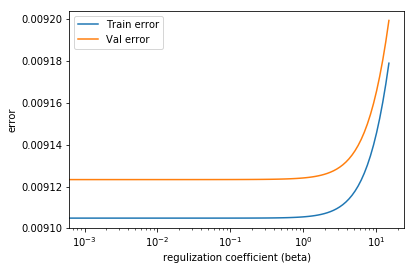

In [30]:
t_start=time.time()
beta_array=train_model_loop(5, 10)
t_end=time.time()
print(f'The time cost is {t_end-t_start}s')

# plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# print(error_cv_reg_multismpl.shape)
print(beta_array)
idx=error_cv_reg.argmin()
beta_best = beta_range[idx]
theta_best = theta_reg[idx]
error_test_reg=computeCost(test_data_norm, test_J, theta_best)

# print('The best value of THETA is ', theta_best)
print('The best value of BETA is ', beta_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# Prediction

In [ ]:
beta_array.mean()

In [ ]:
t=data(test_data)

In [28]:
print(error_cv_reg)

[0.00912332 0.00912332 0.00912332 0.00912332 0.00912332 0.00912332
 0.00912332 0.00912332 0.00912332 0.00912332 0.00912332 0.00912332
 0.00912332 0.00912332 0.00912332 0.00912332 0.00912332 0.00912332
 0.00912332 0.00912332 0.00912332 0.00912333 0.00912333 0.00912333
 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333
 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333
 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333 0.00912333
 0.00912334 0.00912334 0.00912334 0.00912334 0.00912334 0.00912335
 0.00912335 0.00912335 0.00912335 0.00912336 0.00912336 0.00912337
 0.00912337 0.00912338 0.00912339 0.0091234  0.00912341 0.00912343
 0.00912344 0.00912346 0.00912348 0.00912351 0.00912354 0.00912357
 0.00912361 0.00912366 0.00912372 0.00912379 0.00912387 0.00912397
 0.00912409 0.00912423 0.0091244  0.00912459 0.00912483 0.00912511
 0.00912544 0.00912584 0.00912631 0.00912687 0.00912754 0.00912833
 0.00912927 0.00913038 0.00913169 0.00913323 0.00913505 0.0091

In [ ]:
t.polyFeature(2)
t.array.shape

In [ ]:
x=1